### Downloading Data

In [0]:
!wget -O datafile.zip https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip datafile.zip 

In [0]:
import PIL
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import logging

import matplotlib.image as mpimg
import json

from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import torch
import time
import copy
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")



### **Loading Data**

In [0]:
def load_data(foldername = 'PetImages/', train_size = 400, test_size = 1000):

    fileList = []
    for dirname, _, filenames in os.walk(foldername):
        for filename in filenames:
            if filename =='666.jpg' or filename == '11702.jpg':
                continue
            fileList.append(os.path.join(dirname, filename))

    
    classList = []

    for i in range(len(fileList)):
        if 'Cat' in fileList[i]:
            classList.append('Cat')
        else:
            classList.append('Dog')

    df = pd.DataFrame({'filepath':fileList,'label':classList})  

    trainDf,testDf, trainy,testy = train_test_split(df, df.label, train_size = train_size, test_size =test_size)

    return trainDf, testDf
      


In [0]:
trainDf, testDf = load_data(train_size = 400, test_size = 1000)

### **Utils**

#### Helper Functions

In [0]:
def getFeat(net, imgList):

    net.eval()
    featList = []

    with torch.no_grad():
        for i in range(len(imgList)):
            feat = net.getFeatures(imgList[i])
            featList.append(feat.squeeze(0).detach().cpu().numpy())

    return np.array(featList)


def getCDDistribution(net,imgList, labelList ):

    uniqueClasses = [0,1]

    NUM_COLORS = 2

    # featList = []

    # for i in range(len(imgList)):
    #     feat = net.getFeatures(imgList[i])
    #     featList.append(feat.squeeze(0).detach().cpu().numpy())


    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = getFeat(net, imgList)
    X = support

    print(X.shape)

    # scaler = StandardScaler()
    # X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labelList]
    for i in range(len(uniqueClasses)):
      index = np.array(labelList) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()
    
def compareDist(net, criterion, img1, img2, label,  metric = 'cosine',printOutput=True):

    net.eval()

    output1 = net.getFeatures(img1)
    output2 = net.getFeatures(img2)

    if metric == 'cosine':
        dist = 1 - torch.nn.functional.cosine_similarity(output1, output2)
    else:
        dist = torch.nn.functional.pairwise_distance(output1, output2)
        
    loss =  criterion(output1, output2, label) 

    dist = dist.detach().cpu().numpy()

    dist = np.round(dist[0],3)

    if printOutput:
        print(f"Dist : {dist} Loss : {loss} Target Label : {int(label)}")

    return dist, loss




In [0]:
def testModel(net, imgList, labelList, testDataset_):

    correct = 0
    net.eval()

    trainFeat = getFeat(net,imgList)

    knnModel = KNeighborsClassifier(n_neighbors=10, metric='cosine')
    knnModel.fit(trainFeat, labelList)

    for i in tqdm(range(len(testDataset_))):
        predImg, predLabel = testDataset_[i]
        predImg = predImg.cuda().unsqueeze(0)

        testFeat = getFeat(net, [predImg])
        pred = knnModel.predict(testFeat)


        if pred == predLabel:
            correct += 1

    # print(f"Accuracy is : {correct/len(testDataset_)}")

    acc = np.round(correct/len(testDataset_),4)
    return acc


def testModel_(net, imgList, labelList):

    correct = 0
    net.eval()

    trainFeat = getFeat(net,imgList)

    knnModel = KNeighborsClassifier(n_neighbors=10, metric='cosine')
    knnModel.fit(trainFeat, labelList)

    for i in tqdm(range(len(imgList))):
        pred = knnModel.predict(trainFeat[i,:].reshape(1,-1))

        if pred == labelList[i]:
            correct += 1

    # print(f"Accuracy is : {correct/len(imgList)}")

    acc = np.round(correct/len(imgList),4)
    return acc



In [0]:
def predictModel(net, test_dataloader_):

    net.eval()

    labelList = []
    predList = []

    with torch.no_grad():

        for (img,labels) in test_dataloader_:
            img,labels = img.cuda(), labels.cuda()
            
            outputs = net(img)
            _, preds = torch.max(outputs, 1)

            labelList = labelList + list(labels.cpu().numpy())
            predList = predList + list(preds.cpu().numpy())

    return labelList, predList

            

In [0]:
def getSupport(net, dataloader):

    supports = []
    labels = []

    with torch.no_grad():

        net.eval()

        for data in dataloader:
            x,y = data
            x = x.to('cuda')
            feat = net.getFeatures(x)

            supports.append(feat)
            labels.append(y)

    support = torch.cat(supports,axis=0)
    labels = torch.cat(labels,axis=0)

    return support, labels


def compareSamples(index1,index2, metric = 'cosine'):
    img1 = testX[index1].unsqueeze(0).repeat(3,1,1)
    img2 = testX[index2].unsqueeze(0).repeat(3,1,1)

    label1, label2 = testy[index1], testy[index2]

    if label1 ==label2:
        trainLabel = 1
    else:
        trainLabel = 0

    print(f"Labels are {label1} and {label2}")


    feat1 = net.getFeatures(img1.unsqueeze(0).cuda().float())
    feat2 = net.getFeatures(img2.unsqueeze(0).cuda().float())

    if metric=='cosine':
      dist = F.cosine_similarity(feat1, feat2)
    else:
      dist = F.pairwise_distance(feat1,feat2)

    loss = criterion(feat1, feat2, trainLabel)

    print(f"dist is {float(dist)} and loss is {loss}")



def getDistribution(support, labels ):

    uniqueClasses = sorted(pd.Series(labels).unique())

    NUM_COLORS = len(uniqueClasses)

    
    # get_color = matplotlib.colors.LinearSegmentedColormap.from_list(mp, colors=['r', 'y', 'g', 'b'], N=NUM_COLORS)

    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = support.cpu().numpy()

    scaler = StandardScaler()
    X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labels]
    for i in range(len(uniqueClasses)):
      index = np.array(labels) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()


def getClassMap(uniqueClass):

    classMap = {}
    for i in range(len(uniqueClass)):
        classMap[uniqueClass[i]] = i

    classMap_ = {k:v for v,k in classMap.items()}

    return classMap, classMap_

In [0]:
def getPred(net, train_dataloader_, testDataset_, metric = 'cosine', usePCA = False, PCA_components = 10):

    support, labels = getSupport(net, train_dataloader_)

    X = support.cpu().numpy()

    pca = PCA(n_components=PCA_components)
    if usePCA:
      X = pca.fit_transform(X=X)

    knnModel = KNeighborsClassifier(n_neighbors=8,metric=metric)
    knnModel.fit(X, labels)

    labelList = []
    predList = []
    for i in tqdm(range(len(testDataset_))):
        testX = net.getFeatures(testDataset_[i][0].unsqueeze(0).cuda()).detach().cpu().numpy()
        label = int(testDataset_[i][1])
        if usePCA:
          testX = pca.transform(testX)

        pred = knnModel.predict(testX)
        predList.append(pred[0])
        labelList.append(label)

    
    return predList, labelList

In [0]:
def getFeat(net, imgList):

    net.eval()
    featList = []

    with torch.no_grad():
        for i in range(len(imgList)):
            feat = net.getFeatures(imgList[i])
            featList.append(feat.squeeze(0).detach().cpu().numpy())

    return np.array(featList)


def getCDDistribution(net,imgList, labelList ):

    uniqueClasses = [0,1]

    NUM_COLORS = 2

    # featList = []

    # for i in range(len(imgList)):
    #     feat = net.getFeatures(imgList[i])
    #     featList.append(feat.squeeze(0).detach().cpu().numpy())


    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = getFeat(net, imgList)
    X = support

    print(X.shape)

    # scaler = StandardScaler()
    # X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labelList]
    for i in range(len(uniqueClasses)):
      index = np.array(labelList) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()

#### Class Definitions

##### GradCapture

In [0]:
class ModuleHook():
    def __init__(self, module, backward=True):

        self.gradList = []

        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    
    def __getitem__(self,key):
        return self.gradList[key]

    def hook_fn(self, module, grad_input, grad_output):
        self.gradList.append(grad_output.cpu().numpy())

    def close(self):
        self.hook.remove()


class ParamHook():
    def __init__(self, param):
        self.gradList = []
        self.hook = param.register_hook(self.hook_fn)

    def __getitem__(self, key):
        return self.gradList[key]
      
    def hook_fn(self, grad):
        meanGrad = grad.abs().mean().cpu().numpy()
        maxGrad = grad.abs().max().cpu().numpy()
        self.gradList.append([meanGrad,maxGrad])

    def close(self):
        self.hook.remove()


class gradCapture():

   def __init__(self):
     self.paramGradList = {}
     self.gradList = {}

     self.paramHooks = {}
     self.moduleHooks = {}


   def registerHooks(self, model):

     for name, param in net.named_parameters():
       self.paramHooks[name] = ParamHook(param)

   def plotGrad(self, paramList, plotMean = True, plotRange = None):

     length = len(self.paramHooks[list(self.paramHooks.keys())[0]].gradList)
     
     if plotRange :
         x = list(range(plotRange[0], plotRange[1]))
     else:
         x = list(range(length))

     for i in range(len(paramList)):
       key = paramList[i]
       if plotMean:
         y = [i[0] for i in gradCap.paramHooks[key].gradList]
       else:
         y = [i[1] for i in gradCap.paramHooks[key].gradList]

       if plotRange :
        y = np.array(y)[plotRange[0]:plotRange[1]]
    
        
       plt.plot(x,y,label=key)

     plt.legend()


  

##### Siamese Dataset

In [0]:
class SiameseDataset(torch.utils.data.Dataset):
  def __init__(self, df, prob = 0.5, transform = None, classMap= None, classMap_ = None):
    """ 
    df : Dataframe with filename and label columns.


    """
    
    self.df = df
    self.transform = transform
    self.numClasses = df.label.nunique()
    self.uniqueLabels = sorted(df.label.unique())
    self.prob = prob

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(self.df.label.unique())
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):

    is_positive = np.random.random() < self.prob

    if is_positive:
        posLabel = np.random.choice(self.uniqueLabels,1)[0]

        # print(posLabel)
        subDf = self.df[self.df.label == posLabel] 
        subDf = subDf.sample(2, replace = False)
            
        filename1, filename2 = subDf.iloc[0]['filepath'], subDf.iloc[1]['filepath']
        img1, img2 =  Image.open(os.path.join(filename1)).convert('RGB'), Image.open(os.path.join(filename2)).convert('RGB')
        
        target_label = 1
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # img1 = img1/255.0
        # img2 = img2/255.0

    else:

        negLabels = np.random.choice(self.uniqueLabels,2, replace = False)


        subDf1 = self.df[self.df.label == negLabels[0]].sample(1)
        subDf2 = self.df[self.df.label == negLabels[1]].sample(1)

        filename1, filename2 = subDf1.iloc[0]['filepath'], subDf2.iloc[0]['filepath']
        img1, img2 =  Image.open(os.path.join(filename1)).convert('RGB'), Image.open(os.path.join(filename2)).convert('RGB')

        target_label = 0

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # img1 = img1/255.0
        # img2 = img2/255.0


    
    return img1,img2, target_label






##### Image Dataset

In [0]:
#Defining the PyTorch Dataset for retrieving the ships data
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, transform, classMap= None, classMap_ = None):
    
    
    self.df = df
    self.transform = transform

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(self.df.label.unique())
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        
    
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):
    
    filename = self.df.iloc[index]['filepath']
    
    img =  Image.open(os.path.join(filename)).convert('RGB')

    
    label = self.classMap[self.df.iloc[index]['label']]
    
    if self.transform is not None:
        img = self.transform(img)
    
    
    # img = img/255.0
    
    return img, label

In [0]:
class Net2(nn.Module):

    def __init__(self,activation = 'relu'):
        super().__init__()

        self.activation = activation
        self.conv1 = nn.Conv2d(3, 64, 7, stride=(2,2))
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5, stride=(2,2))
        self.conv3 = nn.Conv2d(128, 256,5)
        self.pool2 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(256, 256, 3)
        # self.conv5 = nn.Conv2d(256, 256, 3)
        self.linear = nn.Linear(4096, EMBEDDING_SIZE)


        self.final = self.final = nn.Sequential(
                nn.Linear(EMBEDDING_SIZE,1,bias=False),
                nn.Sigmoid()
                )

        # self.linear2 = nn.Linear(512, 3)

    def getFeatures(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = F.relu(x)


        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        x = F.relu(x)


        return x

    def forward(self, x1, x2):

        out1 = self.getFeatures(x1)
        out2 = self.getFeatures(x2)
        # print(out1)
        # print(out2)
        # h = F.l1_loss(out1,out2,size_average=False,reduce=False)
        h = torch.abs(out1 - out2)

        # print(h)

        out = self.final(h)

        return out



##### ResnetSiamese

In [0]:
class resnetSiamese(torch.nn.Module):
    def __init__(self, arch = 'resnet18', pretrained = True, activation = 'relu'):

        super(resnetSiamese, self).__init__()
        
        if arch == 'resnet18':
            resnetModel_ = torchvision.models.resnet.resnet18(pretrained=pretrained)
        elif arch == 'resnet34':
            resnetModel_ = torchvision.models.resnet.resnet34(pretrained=pretrained)
        else:
            resnetModel_ = torchvision.models.resnet.resnet50(pretrained=pretrained)

        self.activation = activation

        for name,child in resnetModel_.named_children():
          setattr(self, name, getattr(resnetModel_, name))

        if arch == 'resnet50':
            self.linear1 = nn.Linear(4096,EMBEDDING_SIZE)
        else:
            self.linear1 = nn.Linear(512,EMBEDDING_SIZE)

    def getFeatures(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)


        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        if self.activation =='relu':
          x = F.relu(x)
        else:
          x = torch.sigmoid(x)

        x = self.linear1(x)
        
        if self.activation =='relu':
          x = F.relu(x)
        else:
          x = torch.sigmoid(x)
         
        return x

    def forward(self,x1, x2):

        x1 = self.getFeatures(x1)
        x2 = self.getFeatures(x2)

        return x1, x2



##### Contrastive Loss

In [0]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=15.0, metric='cosine'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.metric = metric

    def forward_cosine(self, output1, output2, label):
        euclidean_distance = 1 - torch.nn.functional.cosine_similarity(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive
      
    def forward_euclidean(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

    def forward(self, output1, output2, label):

      if self.metric =='cosine':
        loss = self.forward_cosine(output1, output2, label)
      else:
        loss = self.forward_euclidean(output1, output2, label)
      
      return loss



## **Experiments**

In [0]:
train_transform = transforms.Compose([
                                      transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                                     transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



### **Basic CNN Siamese**

In [0]:
NUM_TRAIN_SAMPLES = 400
NUM_TEST_SAMPLES = 1000
STEPS_PER_EPOCH = 250
NUM_EPOCHS = 50
EMBEDDING_SIZE = 100

#### Network Defintion

In [0]:
def ConvNormRelu(inChannels, outChannels, kernel=5, stride=2):

    module = nn.Sequential(nn.Conv2d(in_channels=inChannels, out_channels=outChannels, kernel_size=kernel, stride = stride ),
                           nn.BatchNorm2d(outChannels),
                           nn.ReLU())

    return module

class Net(nn.Module):

    def __init__(self,activation = 'relu'):
        super().__init__()

        self.activation = activation

        self.pool = nn.MaxPool2d(2)

        self.conv1 = ConvNormRelu(3,64,7,2)
        self.conv2 = ConvNormRelu(64,128,5,2)
        self.conv3 = ConvNormRelu(128,256,5,1)
        self.conv4 = ConvNormRelu(256,256,3,1)
         
        self.drop = nn.Dropout2d(0.1)
        
        self.linear = nn.Linear(4096, EMBEDDING_SIZE)



    def getFeatures(self, x):

        x = self.conv1(x)
        x = self.pool(x)
        x = self.drop(x)

        x = self.conv2(x)

        x = self.conv3(x)
        x = self.drop(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.pool(x)
        x = self.drop(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)

        if self.activation=='relu':
            x = F.relu(x)
        else:
            x = torch.sigmoid(x)

        return x

    def forward(self, x1, x2):

        out1 = self.getFeatures(x1)
        out2 = self.getFeatures(x2)

        return out1, out2

In [0]:
net = Net(activation = 'relu')


gradCap = gradCapture()
gradCap.registerHooks(net)

net.to('cuda')

criterion = ContrastiveLoss(margin=0.4, metric='cosine')

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.00001 )



#### **Defining Datasets**

In [0]:
trainDf,testDf = load_data(train_size = NUM_TRAIN_SAMPLES, test_size = NUM_TEST_SAMPLES)

trainDataset = SiameseDataset(trainDf, prob = 0.5, transform=train_transform)

trainDataset_ = ImageDataset(trainDf, transform = train_transform)
testDataset_ = ImageDataset(testDf, transform = test_transform, classMap = trainDataset_.classMap, classMap_= trainDataset_.classMap_)

train_dataloader = DataLoader(trainDataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=10)

train_dataloader_ = DataLoader(trainDataset_,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)

test_dataloader_ = DataLoader(testDataset_,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)

In [0]:
### Setting Training Data
indexes = list(range(NUM_TRAIN_SAMPLES))

trainImgList = []
trainLabelList = []

for i in range(len(indexes)):
    x, y = trainDataset_[indexes[i]]
    trainImgList.append(x)
    trainLabelList.append(y)
    trainImgList[i] = trainImgList[i].cuda().unsqueeze(0)

#### Training Loop

In [45]:
for epoch in tqdm(range(5)):
    for i in range(STEPS_PER_EPOCH):
        selectIndex = np.random.choice(list(range(len(indexes))),2, replace = False)
        img1, img2 = trainImgList[selectIndex[0]], trainImgList[selectIndex[1]]

        label1,label2 = trainLabelList[selectIndex[0]], trainLabelList[selectIndex[1]]

        target_label = int(label1 == label2)
        label = torch.FloatTensor([target_label]).cuda()

        img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

        # dist_, loss_ = compareDist(net, criterion, img1, img2, label, printOutput=False)

        net.train()
        optimizer.zero_grad()
        output1,output2 = net(img1,img2)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        # scheduler.step()

        # dist, loss = compareDist(net, criterion, img1, img2, label, printOutput=False)
        # print(f"Indexes : [{selectIndex[0]},{selectIndex[1]}] Label : {int(label)} Old dist : {np.round(dist_,4)} New dist : {np.round(dist,4)}")

    # testAcc = testModel(net,imgList, labelList, testDataset_)
    trainAcc = testModel_(net,trainImgList, trainLabelList)

    print(f"Train Acc : {trainAcc}")


 20%|██        | 1/5 [00:04<00:16,  4.04s/it]

Train Acc : 0.9725



 40%|████      | 2/5 [00:07<00:11,  3.99s/it]

Train Acc : 0.9725



 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

Train Acc : 0.96



 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

Train Acc : 0.9625



100%|██████████| 5/5 [00:19<00:00,  3.94s/it]

Train Acc : 0.965


#### **Evaluation**

(400, 100)
Variance Explained : 0.752348780632019


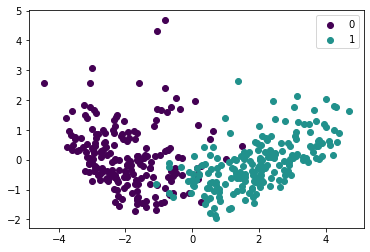

In [46]:
getCDDistribution(net, trainImgList, trainLabelList)

In [47]:
testAcc = testModel(net,trainImgList, trainLabelList, testDataset_)
trainAcc = testModel_(net,trainImgList, trainLabelList)

print(f"Train Acc : {trainAcc} Test Acc : {testAcc}")


100%|██████████| 400/400 [00:00<00:00, 734.18it/s]

Train Acc : 0.965 Test Acc : 0.616


### **Resnet18 Siamese**

In [0]:
NUM_TRAIN_SAMPLES = 400
NUM_TEST_SAMPLES = 1000
STEPS_PER_EPOCH = 250
NUM_EPOCHS = 3
EMBEDDING_SIZE = 100

#### Network Definition

In [0]:
net = resnetSiamese(arch = 'resnet18', pretrained = True)

net = net.cuda()

#### Defining Datasets

In [0]:
trainDf,testDf = load_data(train_size = NUM_TRAIN_SAMPLES, test_size = NUM_TEST_SAMPLES)

trainDataset = SiameseDataset(trainDf, prob = 0.5, transform=train_transform)

trainDataset_ = ImageDataset(trainDf, transform = train_transform)
testDataset_ = ImageDataset(testDf, transform = test_transform, classMap = trainDataset_.classMap, classMap_= trainDataset_.classMap_)

train_dataloader = DataLoader(trainDataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=10)

train_dataloader_ = DataLoader(trainDataset_,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)

test_dataloader_ = DataLoader(testDataset_,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)

#### **Training Loop**

Variance Explained : 0.14592072367668152


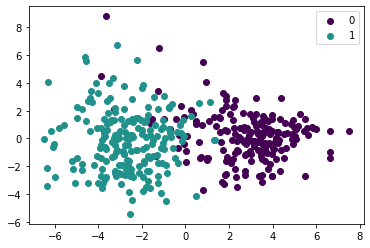

Epoch Loss : 0.025086282729171218
Variance Explained : 0.2907048761844635


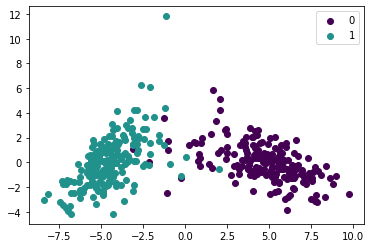

In [66]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.00001 )


net.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    support, labels = getSupport(net, train_dataloader_)
    getDistribution(support, labels)
    plt.show()

    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
 
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss.append(loss_contrastive.item())


    print(f"Epoch Loss : {np.mean(epoch_loss)}")


support, labels = getSupport(net, train_dataloader_)
getDistribution(support, labels)
plt.show()

    

In [67]:
pred, label = getPred(net, train_dataloader_, testDataset_, metric ='cosine')

accuracy_score(label, pred)

100%|██████████| 1000/1000 [00:27<00:00, 37.00it/s]


0.976

### Resnet18 CNN

In [0]:
NUM_TRAIN_SAMPLES = 400
NUM_TEST_SAMPLES = 1000
STEPS_PER_EPOCH = 250
NUM_EPOCHS = 30

#### Network Definition

In [0]:
#Resnet
net = torchvision.models.resnet.resnet18(pretrained = True)
for param in net.parameters():
    param.requires_grad = False

net.fc = nn.Linear(512,2)

net = net.cuda()

#### Defining Datasets

In [0]:
trainDf,testDf = load_data(train_size = NUM_TRAIN_SAMPLES, test_size = NUM_TEST_SAMPLES)

trainDataset = ImageDataset(trainDf, transform = train_transform)
testDataset = ImageDataset(testDf, transform = train_transform, classMap = trainDataset.classMap, classMap_=trainDataset.classMap_)

train_dataloader = DataLoader(trainDataset,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)
test_dataloader = DataLoader(testDataset,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)



#### **Training Loop**

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.00001 )

net.train()

for epoch in range(0,NUM_EPOCHS):
    epoch_loss = []
   
    net.train()
    

    for i, data in enumerate(train_dataloader):
        img, label = data
        img, label = img.cuda() , label.cuda()
 
        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    labels,preds = predictModel(net, test_dataloader)
    acc = accuracy_score(labels, preds)

    print(f"Epoch Loss : {np.mean(epoch_loss)} Val Acc : {np.round(acc,3)}")
    
    


# support, labels = getSupport(net, train_dataloader_)
# getDistribution(support, labels)
# plt.show()

    

Epoch Loss : 0.5223360322415829 Val Acc : 0.824
Epoch Loss : 0.5066586516797542 Val Acc : 0.851
Epoch Loss : 0.5040842168033123 Val Acc : 0.851
Epoch Loss : 0.5001017026603222 Val Acc : 0.861
Epoch Loss : 0.48609235808253287 Val Acc : 0.869
Epoch Loss : 0.4758606366813183 Val Acc : 0.875
Epoch Loss : 0.4699165552854538 Val Acc : 0.884
Epoch Loss : 0.4705142594873905 Val Acc : 0.884
Epoch Loss : 0.4591732405126095 Val Acc : 0.892
Epoch Loss : 0.44819404631853105 Val Acc : 0.897
